# Partial Borrowers

This notebook identifies S&co library members with incomplete borrowing history - that is, members who have some borrowing records but it does not cover all of their known subscriptions.


In [4]:
# add project root to path so we can import utility methods
import sys
sys.path.append('..')

from utils.missing_data_processing import load_initial_data, preprocess_events_data, short_id

In [5]:
# load datasets
events_df, members_df, books_df, borrow_overrides_df = load_initial_data()

# preprocess to split shared account members and generate short ids for members and items
events_df = preprocess_events_data(events_df)
# generate short ids so we can easily match on member ids in partial borrowers
members_df["id"] = members_df.uri.apply(short_id)


## Apply borrow corrections

In the course of our research, we discovered long-duration borrow events (duration longer than a year) that had been incorrectly entered; these errors will be corrected in the next official dataset, but since they impact our results we include a list of corrections and apply them

In [6]:
# incorporate overrides for incorrect long borrows
borrow_overrides_df.head()


,event_type,member_uris,item_uri,start_date,end_date,borrow_duration_days,match_date
0,Borrow,https://shakespeareandco.princeton.edu/members...,https://shakespeareandco.princeton.edu/books/w...,1925-02-11,1925-03-04,21.0,end_date
1,Borrow,https://shakespeareandco.princeton.edu/members...,https://shakespeareandco.princeton.edu/books/h...,1924-10-16,1924-10-30,14.0,start_date
2,Borrow,https://shakespeareandco.princeton.edu/members...,https://shakespeareandco.princeton.edu/books/l...,1924-10-25,1924-12-20,56.0,start_date
3,Borrow,https://shakespeareandco.princeton.edu/members...,https://shakespeareandco.princeton.edu/books/g...,1928-02-09,1928-02-15,6.0,end_date
4,Borrow,https://shakespeareandco.princeton.edu/members...,https://shakespeareandco.princeton.edu/books/d...,1928-03-06,1928-03-28,22.0,start_date


### Borrow events longer than a year (before corrections)

In [7]:
# report on year+ borrows before applying corrections
yearplus_borrows = events_df[(events_df.event_type == 'Borrow') & (events_df.borrow_duration_days > 365)]
print('%d year+ borrows' % yearplus_borrows.shape[0])
yearplus_borrows[['start_date', 'end_date', 'member_id', 'item_id', 'borrow_duration_days']].sort_values('borrow_duration_days', ascending=False).head(10)

49 year+ borrows


,start_date,end_date,member_id,item_id,borrow_duration_days
2652,1922-12-30,1932-05-02,porel,hardy-trumpet-major,3411.0
3415,1923-10-18,1931-01-30,joyce-james,colum-castle-conquer,2661.0
3409,1923-10-16,1931-01-10,joyce-james,ludovici-woman-vindication,2643.0
3417,1923-10-18,1931-01-10,joyce-james,doughty-travels-arabia-deserta,2641.0
5649,1925-10-14,1931-01-10,joyce-james,huxley-barren-leaves,1914.0
5650,1925-10-14,1931-01-10,joyce-james,huxley-antic-hay,1914.0
5764,1925-11-14,1931-01-10,joyce-james,sterne-works-sterne-life,1883.0
5767,1925-11-14,1931-01-10,joyce-james,sterne-works-sterne-life,1883.0
11975,1931-03-27,1934-12-17,wilde-dorothy,cruttwell-madame-maintenon,1361.0
6204,1926-02-22,1929-03-18,du-bos,dupre-italien-dangleterre-poe,1120.0


In [9]:
for borrow in borrow_overrides_df.itertuples():
    member_item_borrows = events_df[
        (events_df.event_type == "Borrow")
        & (events_df.member_uris == borrow.member_uris)
        & (events_df.item_uri == borrow.item_uri)
    ]
    if borrow.match_date == "start_date":
        # get the *index* of the row to update
        update_index = member_item_borrows.index[
            member_item_borrows.start_date == borrow.start_date
        ]
    elif borrow.match_date == "end_date":
        update_index = member_item_borrows.index[
            member_item_borrows.end_date == borrow.end_date
        ]

    # update with correct dates & borrow duration
    events_df.loc[update_index, "start_date"] = borrow.start_date
    events_df.loc[update_index, "end_date"] = borrow.end_date
    events_df.loc[
        update_index, "borrow_duration_days"
    ] = borrow.borrow_duration_days

### Borrow events longer than a year (after corrections)

In [10]:
# report on year+ borrows after applying corrections
yearplus_borrows = events_df[(events_df.event_type == 'Borrow') & (events_df.borrow_duration_days > 365)]
print('%d year+ borrows' % yearplus_borrows.shape[0])
yearplus_borrows[['start_date', 'end_date', 'member_id', 'item_id', 'borrow_duration_days']].sort_values('borrow_duration_days', ascending=False).head(10)

24 year+ borrows


,start_date,end_date,member_id,item_id,borrow_duration_days
2652,1922-12-30,1932-05-02,porel,hardy-trumpet-major,3411.0
3415,1923-10-18,1931-01-30,joyce-james,colum-castle-conquer,2661.0
3409,1923-10-16,1931-01-10,joyce-james,ludovici-woman-vindication,2643.0
3417,1923-10-18,1931-01-10,joyce-james,doughty-travels-arabia-deserta,2641.0
5649,1925-10-14,1931-01-10,joyce-james,huxley-barren-leaves,1914.0
5650,1925-10-14,1931-01-10,joyce-james,huxley-antic-hay,1914.0
5767,1925-11-14,1931-01-10,joyce-james,sterne-works-sterne-life,1883.0
5764,1925-11-14,1931-01-10,joyce-james,sterne-works-sterne-life,1883.0
11975,1931-03-27,1934-12-17,wilde-dorothy,cruttwell-madame-maintenon,1361.0
6204,1926-02-22,1929-03-18,du-bos,dupre-italien-dangleterre-poe,1120.0


# Information about partial borrowers


In [19]:
import pandas as pd

from identify_partial_borrowers import PARTIAL_BORROWERS_CSV, PARTIAL_BORROWERS_COLLAPSED_CSV

# load previously computed partial borrowers list (sequential / near sequential subscriptions collapsed)
partial_borrowers = pd.read_csv(PARTIAL_BORROWERS_COLLAPSED_CSV)

# sort by number of known borrows, highest first
partial_borrowers.sort_values('known_borrows', ascending=False, inplace=True)

partial_borrowers.head()

,member_id,subscription_start,subscription_end,subscription_events,subscription_volumes,subscription_days,internal_gaps,known_borrows
23,raphael-france,1920-04-30,1921-11-17,Subscription;Renewal;Renewal;Renewal,1.0,566,0;0;0,1008
86,kittredge-eleanor-hayden,1924-01-17,1924-05-17,Subscription;Renewal,2.0,121,0,583
89,kittredge-eleanor-hayden,1929-09-10,1929-12-10,Subscription,2.0,91,NaN,583
88,kittredge-eleanor-hayden,1928-09-05,1928-12-05,Renewal,2.0,91,NaN,583
87,kittredge-eleanor-hayden,1924-11-24,1926-03-23,Subscription;Renewal;Renewal;Renewal;Renewal,2.0,484,0;0;0;0,583


How many unique members with partial borrowing records?

What is the distribution of how many borrows we know for them?

In [17]:
len(partial_borrowers.member_id.unique())

103

In [20]:
partial_borrowers.known_borrows.describe()

count     136.000000
mean       74.794118
std       151.429931
min         1.000000
25%         6.750000
50%        22.500000
75%        83.500000
max      1008.000000
Name: known_borrows, dtype: float64

### How many members with only one known borrow event?



In [23]:
single_borrows = partial_borrowers[partial_borrowers.known_borrows == 1]

print(f"{len(single_borrows)} partial borrowers with only one borrow event")

single_borrows

13 partial borrowers with only one borrow event


,member_id,subscription_start,subscription_end,subscription_events,subscription_volumes,subscription_days,internal_gaps,known_borrows
132,brooks-alden,1921-09-19,1922-10-18,Subscription;Renewal,2.0,394,0,1
13,gros-2,1935-10-22,1936-05-15,Subscription;Renewal;Renewal;Renewal;Renewal,1.0,206,0;0;0;0,1
120,bishop-elizabeth,1935-11-04,1936-03-03,Subscription;Renewal,NaN,120,0,1
103,goodwin-3,1935-10-16,1935-11-16,Subscription,1.0,31,NaN,1
98,harmsworth-desmond,1928-08-31,1929-08-31,Subscription,1.0,365,NaN,1
96,duteurtre,1934-04-11,1934-05-11,Subscription,1.0,30,NaN,1
95,la-gorce-agnes-de,1929-03-06,1929-07-06,Subscription;Renewal;Renewal;Renewal,1.0,122,0;0;0,1
9,lafleur,1936-11-26,1936-12-26,Subscription,1.0,30,NaN,1
12,nguyen-minh-truyet,1936-09-04,1937-01-11,Subscription;Subscription,1.0,129,0,1
80,brody-rachel,1933-01-19,1933-02-19,Subscription,1.0,31,NaN,1


### What about partial borrowers with more than 400 known borrows?


In [26]:
multi_borrows = partial_borrowers[partial_borrowers.known_borrows > 400]

print(f"{len(multi_borrows)} partial borrowers with more than 400 known borrow events")

multi_borrows

9 partial borrowers with more than 400 known borrow events


,member_id,subscription_start,subscription_end,subscription_events,subscription_volumes,subscription_days,internal_gaps,known_borrows
23,raphael-france,1920-04-30,1921-11-17,Subscription;Renewal;Renewal;Renewal,1.0,566,0;0;0,1008
86,kittredge-eleanor-hayden,1924-01-17,1924-05-17,Subscription;Renewal,2.0,121,0,583
89,kittredge-eleanor-hayden,1929-09-10,1929-12-10,Subscription,2.0,91,NaN,583
88,kittredge-eleanor-hayden,1928-09-05,1928-12-05,Renewal,2.0,91,NaN,583
87,kittredge-eleanor-hayden,1924-11-24,1926-03-23,Subscription;Renewal;Renewal;Renewal;Renewal,2.0,484,0;0;0;0,583
7,colens-fernand,1920-04-01,1920-07-07,Subscription;Subscription,1.5,97,0,575
8,colens-fernand,1920-10-30,1927-11-26,Subscription;Renewal;Renewal;Renewal;Renewal;R...,NaN,2583,0;0;0;0;0;0;0;0;0;0,575
2,morgan,1926-06-04,1928-06-04,Renewal;Renewal,1.0,731,0,426
3,morgan,1929-02-21,1930-02-21,Renewal,1.0,365,NaN,426


In [27]:
# parse subscription dates 
partial_borrowers['subscription_start'] = pd.to_datetime(partial_borrowers['subscription_start'])
partial_borrowers['subscription_end'] = pd.to_datetime(partial_borrowers['subscription_end'])

For members with partial borrowing histories and lots of data, we want to know:

- years active
- average subscription duration
- subscription volumes 
— known borrowing activity

Whether their subscriptions are continuous or discrete

In [29]:
def year_ranges(years):
  # convert list of years active into more readable ranges
  years = years.split(';')
  ranges = []
  range_start = None
  range_end = None
  for y in years:
    y = int(y)
    # initialize new range if no range is active
    if range_start is None:
      range_start = y 
      range_end = y
    # extend current range if next year is sequential
    elif range_end + 1 == y:
      range_end = y
    else:
      # if not sequential, end this range and start a new one
      ranges.append((range_start, range_end))
      range_start = range_end = None

  if range_start and range_end:
    # add the last range to the list  
    ranges.append((range_start, range_end))
  return ranges 


In [30]:
for member_id in partial_borrowers.sort_values('known_borrows', ascending=False).member_id.unique():  # limit to first n for dev/debug
  # limit to our case studies for now
  # if member_id not in ['kittredge-eleanor-hayden', 'colens', 'raphael-france', 'hemingway']:  # v1.1 ids
  if member_id not in ['kittredge-eleanor-hayden', 'colens-fernand', 'raphael-france', 'hemingway-ernest']:
   continue

  # output member summary info & demographics
  member_info = members_df[members_df.id == member_id].to_dict('records')[0]
  # convert pandas NaN to python None
  for k, v in member_info.items():
    val = v if pd.notna(v) else None
    # title is used only for display, convert to empty string
    if k == 'title':
      val = ''
    member_info[k] = val

  print('\n%(title)s %(name)s / %(sort_name)s' % member_info)
  print('%(uri)s' % member_info)
  memberyear_ranges = year_ranges(member_info['membership_years'])
  print('membership years: %s' % '; '.join(('%s—%s' % (start, end) if start != end else str(start)) for start, end in memberyear_ranges))

  partialborrow_info = partial_borrowers[partial_borrowers.member_id == member_id].sort_values('subscription_start')
  print('subscriptions without borrowing events')
  for sub in partialborrow_info.itertuples():
    print('   %s — %s (%d days, %s volumes)' % 
          (sub.subscription_start.strftime('%Y-%m-%d'), sub.subscription_end.strftime('%Y-%m-%d'), 
           sub.subscription_days, sub.subscription_volumes if pd.notna(sub.subscription_volumes) else 'unknown'))
    print('   subscription events: %s' % sub.subscription_events)
    # report on any internal gaps within this subscription period
    if pd.notna(sub.internal_gaps) and any(gap != '0' for gap in sub.internal_gaps.split(';')):
      print('   gaps between subscriptions in days: %s' % sub.internal_gaps)
    # subscription_events 	subscription_volumes 	subscription_days 	internal_gaps

  print('  gender: %(gender)s' % member_info)
  if member_info['nationalities']:
    print('  nationality: %(nationalities)s' % member_info)
  # print(member_info)
  if member_info['birth_year'] or member_info['death_year']:
    print('%s — %s' % (int(member_info['birth_year']) if member_info['birth_year'] else '', int(member_info['death_year']) if member_info['death_year'] else ''))
  if member_info['viaf_url']:
    print('  viaf: %(viaf_url)s' % member_info)
  if member_info['wikipedia_url']:
    print('  wikipedia: %(wikipedia_url)s' % member_info)
  if member_info['addresses']:
    addresses = member_info['addresses'].split(';')
    print('%d known address(es):' % len(addresses))
    for addr in addresses:
        print('  %s' % addr)
  if member_info['notes']:
    print('Notes: %(notes)s' % member_info)

  # then look at member events
  member_events = events_df[events_df.member_id == member_id]
  # print(member_events)
  subs = member_events[member_events.event_type.isin(['Subscription', 'Renewal', 'Supplement'])]
  print('%d subscription events' % subs.shape[0])
  print('%.2f average subscription length in days (min %d, max %d)' % (subs.subscription_duration_days.mean(), subs.subscription_duration_days.min(), subs.subscription_duration_days.max()))
  print('%.2f average subscription volumes' % subs.subscription_volumes.mean())

  # look briefly at all book events
  book_events = member_events[member_events.item_id.notna()]
  # number of unique authors could be interesting;
  # also unique item types? (e.g. books vs periodical)
  borrows = book_events[book_events.event_type == 'Borrow']
  print('%d book events, %d borrows, %d unique titles' % (book_events.shape[0], borrows.shape[0], len(book_events.item_uri.unique())))
  try:
    print('%.2f average borrow duration days (min %d, max %d)' % (borrows.borrow_duration_days.mean(), borrows.borrow_duration_days.min(), borrows.borrow_duration_days.max()))
  except ValueError:
    print('no known borrow duration')


 France Emma Raphaël / Raphaël, France Emma
https://shakespeareandco.princeton.edu/members/raphael-france/
membership years: 1920—1942
subscriptions without borrowing events
   1920-04-30 — 1921-11-17 (566 days, 1.0 volumes)
   subscription events: Subscription;Renewal;Renewal;Renewal
  gender: Female
  nationality: France;Netherlands
1877 — 1962
  viaf: http://viaf.org/viaf/89805143/
5 known address(es):
  40 avenue de Saxe, Paris
  Hôtel des Roches Rouges, 90 boulevard de la 36ème division du Texas, Saint-Raphaël
  18 rue Boissonade, Paris
  40 rue Boissonade, Paris
  1 rue Traverse Brest, Brest
26 subscription events
300.00 average subscription length in days (min 14, max 366)
1.00 average subscription volumes
1008 book events, 999 borrows, 920 unique titles
9.67 average borrow duration days (min 1, max 67)

 Eleanor (Hayden) Kittredge / Mrs. Tracy B. Kittredge / Kittredge, Eleanor
https://shakespeareandco.princeton.edu/members/kittredge-eleanor-hayden/
membership years: 1924—1926;

In [32]:
import seaborn as sns
sns.set_theme(style="whitegrid")
#ax = sns.violinplot(x=member_borrows.borrow_duration_days)


kittredge-eleanor-hayden


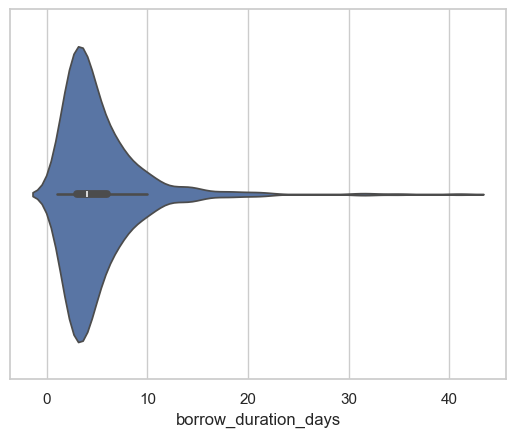

colens-fernand


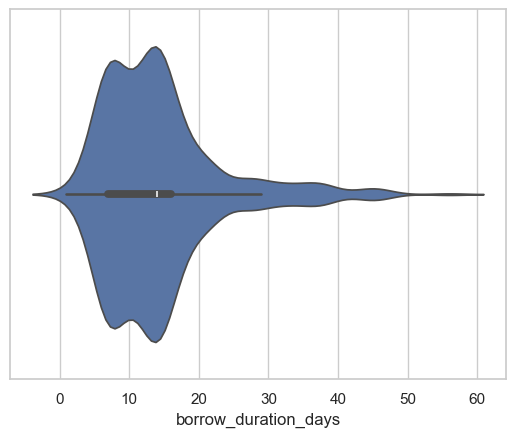

raphael-france


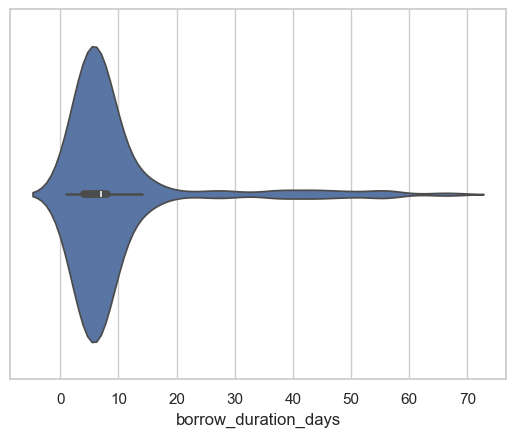

hemingway-ernest


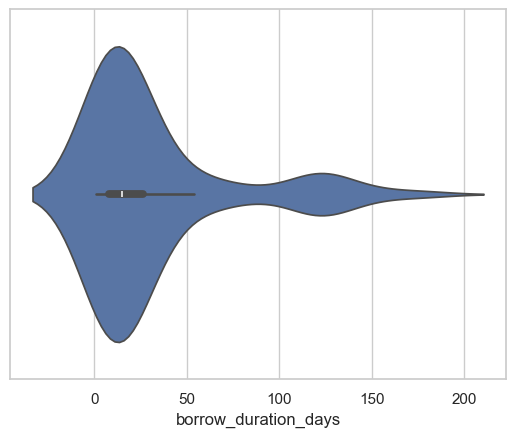

In [33]:
import matplotlib.pyplot as plt 
for member_id in ['kittredge-eleanor-hayden', 'colens-fernand', 'raphael-france', 'hemingway-ernest']:
   print(member_id)
   member_borrows = events_df[(events_df.member_id == member_id) & (events_df.event_type == 'Borrow')]
   ax = sns.violinplot(x=member_borrows.borrow_duration_days)
   plt.show()

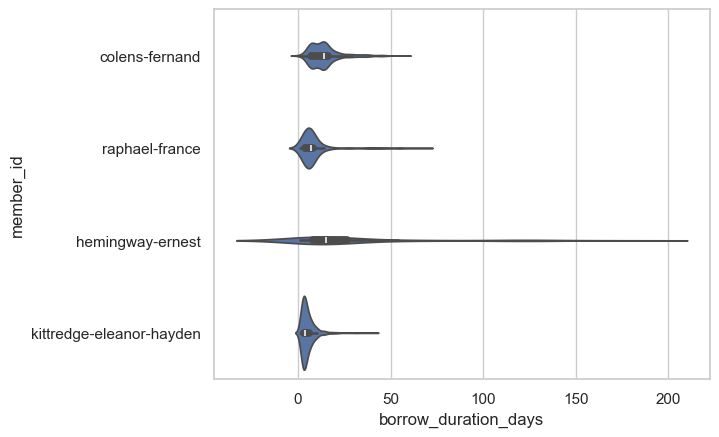

In [34]:
case_study_borrows = events_df[events_df.member_id.isin(['kittredge-eleanor-hayden', 'colens-fernand', 'raphael-france', 'hemingway-ernest']) & (events_df.event_type == 'Borrow')]

ax = sns.violinplot(y="member_id", x="borrow_duration_days", data=case_study_borrows)


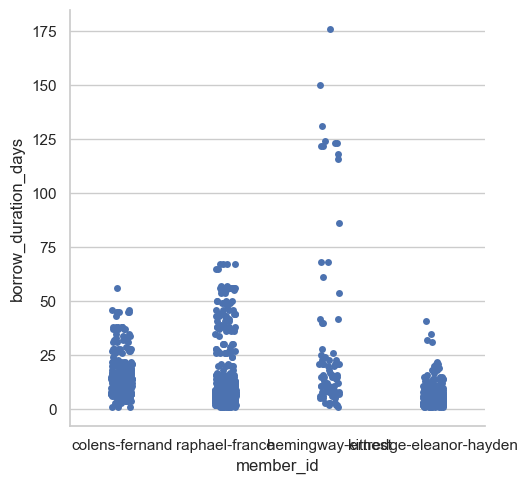

In [35]:
sns.catplot(x="member_id", y="borrow_duration_days", data=case_study_borrows)


In [36]:
# hemingways' longer borrows
hemingway_borrows = events_df[events_df.member_id.isin(['hemingway-ernest']) & (events_df.event_type == 'Borrow')]
hemingway_borrows.sort_values('borrow_duration_days', ascending=False)[['borrow_duration_days', 'item_uri', 'item_title', 'start_date','end_date']].head(12)


,borrow_duration_days,item_uri,item_title,start_date,end_date
6651,176.0,https://shakespeareandco.princeton.edu/books/t...,Knock Knock Knock and Other Stories,1926-05-10,1926-11-02
6619,150.0,https://shakespeareandco.princeton.edu/books/h...,Far Away and Long Ago,1926-05-04,1926-10-01
6627,131.0,https://shakespeareandco.princeton.edu/books/n...,Thus Spake Zarathustra: A Book for All and None,1926-05-05,1926-09-13
5916,124.0,https://shakespeareandco.princeton.edu/books/h...,Children of the Age,1925-12-10,1926-04-13
6649,123.0,https://shakespeareandco.princeton.edu/books/t...,The Two Friends and Other Stories,1926-05-10,1926-09-10
6652,123.0,https://shakespeareandco.princeton.edu/books/t...,On the Eve,1926-05-10,1926-09-10
7244,122.0,https://shakespeareandco.princeton.edu/books/a...,On the Trail of Ancient Man,1926-10-29,1927-02-28
6661,122.0,https://shakespeareandco.princeton.edu/books/r...,The Problems of Philosophy,1926-05-14,1926-09-13
10705,118.0,https://shakespeareandco.princeton.edu/books/d...,The Idiot,1929-09-27,1930-01-23
7265,116.0,https://shakespeareandco.princeton.edu/books/s...,Composition as Explanation,1926-11-04,1927-02-28


In [25]:
# hemingways' short borrows
hemingway_borrows.sort_values('borrow_duration_days', ascending=True)[['borrow_duration_days', 'item_uri', 'item_title', 'start_date','end_date']].head(12)

,borrow_duration_days,item_uri,item_title,start_date,end_date
8395,1.0,https://shakespeareandco.princeton.edu/books/l...,Time and Western Man,1927-10-18,1927-10-19
8035,2.0,https://shakespeareandco.princeton.edu/books/l...,The Story of a Wonder Man: Being the Autobiogr...,1927-06-11,1927-06-13
10348,2.0,https://shakespeareandco.princeton.edu/books/r...,A Bookman's Daybook,1929-06-03,1929-06-05
8751,2.0,https://shakespeareandco.princeton.edu/books/m...,The Riddle of the Irish,1928-02-11,1928-02-13
10424,3.0,https://shakespeareandco.princeton.edu/books/m...,Contemporary Russian Literature: 1881 – 1925,1929-06-21,1929-06-24
23241,3.0,https://shakespeareandco.princeton.edu/books/l...,The Dead Don't Care,1938-09-07,1938-09-10
10446,3.0,https://shakespeareandco.princeton.edu/books/b...,"Politicians and the War, 1914 – 1916",1929-06-29,1929-07-02
5840,3.0,https://shakespeareandco.princeton.edu/books/o...,The Terrible Hobby of Sir Joseph Londe,1925-11-28,1925-12-01
8811,5.0,https://shakespeareandco.princeton.edu/books/g...,The Wonder Book of the Wild: The Romance of Ex...,1928-03-03,1928-03-08
6107,5.0,https://shakespeareandco.princeton.edu/books/c...,The Doctor Looks at Literature: Psychological ...,1926-01-28,1926-02-02


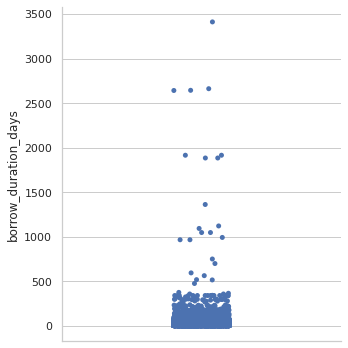

In [26]:
all_borrows = events_df[events_df.event_type == 'Borrow']
sns.catplot(y="borrow_duration_days", data=all_borrows)


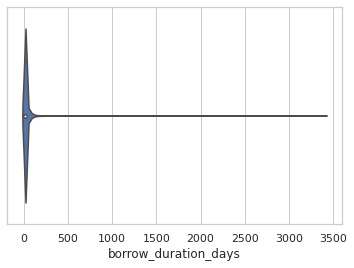

In [27]:
ax = sns.violinplot(x=all_borrows.borrow_duration_days)

In [28]:
all_borrows.borrow_duration_days.describe()

count    19728.000000
mean        17.492245
std         60.789850
min          1.000000
25%          4.000000
50%          8.000000
75%         16.000000
max       3411.000000
Name: borrow_duration_days, dtype: float64

In [29]:
# get uncollapsed partial borrows to check exact subscription duration & volumes
partial_borrowers_full = pd.read_csv("https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/data/partial_borrowers.csv")
partial_borrowers_full['subscription_start'] = pd.to_datetime(partial_borrowers_full.subscription_start)
partial_borrowers_full['subscription_end'] = pd.to_datetime(partial_borrowers_full.subscription_end)
partial_borrowers_full['subscription_duration'] = partial_borrowers_full.apply(lambda x: x.subscription_end - x.subscription_start, axis=1)

# duration days * volumes
partial_borrowers_full['duration_days_volumes'] = partial_borrowers_full.apply(lambda x: x.subscription_duration * x.subscription_volumes, axis=1)

partial_borrowers_full[partial_borrowers_full.member_id == 'hemingway'].sort_values('subscription_start')

,member_id,subscription_start,subscription_end,subscription_type,subscription_volumes,known_borrows,subscription_duration,duration_days_volumes


In [30]:
# total subscription days
subscription_days = partial_borrowers_full[partial_borrowers_full.member_id == 'hemingway'].subscription_duration.sum()
print(subscription_days)
# subscription days * volumes
subscription_volume_days = partial_borrowers_full[partial_borrowers_full.member_id == 'hemingway'].duration_days_volumes.sum()
print(subscription_volume_days)


0 days 00:00:00
0 days 00:00:00


In [31]:
# 1 book / ~32 days (Hemingway's average) * 577 days 
(1/32) * subscription_days.days

0.0

In [32]:
(1/32) * subscription_volume_days.days

0.0

In [33]:
# library wide borrow duration days mean is 18.039521 
# using v1.2 with long borrow overrides, is now 17.492245
(1/17.5) * subscription_volume_days.days

0.0

In [34]:
!pip install ptitprince

     |████████████████████████████████| 51 kB 494 kB/s 
  Created wheel for ptitprince: filename=ptitprince-0.2.5-py3-none-any.whl size=8426 sha256=5201a158edcfdc3d46b02609d59d254ab9073b8071c8b647d138535fa2043ece
  Stored in directory: /root/.cache/pip/wheels/58/a5/f2/55920bbc5d0e6fb74b2370e1e52e07c236ba7b621236ea5a81
Successfully built ptitprince


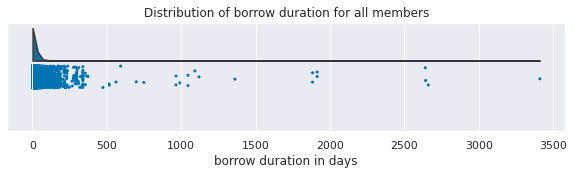

In [35]:
# raincloud plot adapted from Zoe's code

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.collections as clt
import ptitprince as pt

def raincloud_borrow_plot(df, img_filename, duration_for='all members'):
  dx="borrow_duration_days"
  pal = sns.color_palette('colorblind')
  sns.set(style="darkgrid")
  f, ax = plt.subplots(figsize=(10, 2))
  ax = pt.half_violinplot(x=dx, data=df, palette=pal, bw=.2, cut=0., scale = "area", width=.6, inner = None) 
  ax=sns.stripplot(x=dx,data=df, palette=pal, edgecolor="white", size = 3, jitter = 1, zorder = 0) 

  ax.set_title('Distribution of borrow duration for %s' % duration_for)
  ax.set_xlabel('borrow duration in days')
  plt.show()
  ax.figure.savefig(img_filename)

raincloud_borrow_plot(all_borrows, 'all_borrow_duration_raincloud_plot.png')


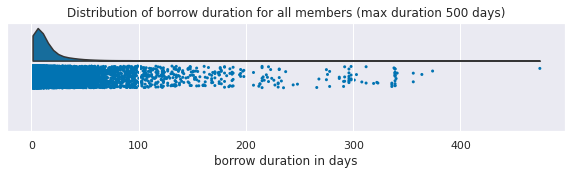

In [36]:
# all member borrows with duration less than 500 days
raincloud_borrow_plot(all_borrows[all_borrows.borrow_duration_days < 500], 'all_borrow_max500_duration_raincloud_plot.png', duration_for='all members (max duration 500 days)')

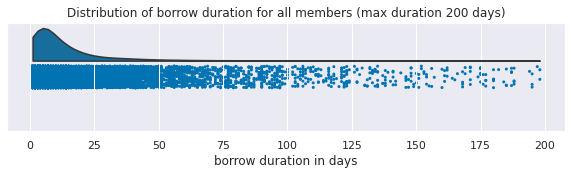

In [37]:
# all member borrows with duration less than 200 days
raincloud_borrow_plot(all_borrows[all_borrows.borrow_duration_days < 200], 'all_borrow_max200_duration_raincloud_plot.png', 'all members (max duration 200 days)')

# case studies


## setup/prep

In [38]:
# event types and field names for filtering and reporting on membership
membership_events = ['Subscription', 'Renewal', 'Supplement', 'Separate Deposit', 'Reimbursement']
membership_fields = ['event_type', 'subscription_purchase_date', 'start_date', 'end_date', 'subscription_price_paid', 'subscription_deposit', 'subscription_duration_days', 'subscription_volumes', 'subscription_category', 'reimbursement_refund']

### load subject/genre data

In [39]:
# load genre data for summarizing/categorizing books that our case study members read
genre_df = pd.read_csv('https://github.com/ZoeLeBlanc/unknown_borrowers/raw/main/dataset_generator/data/SCoData_books_genre.csv')

In [40]:
genre_df.head()

,item_id,term,type,source
0,malory-morte-darthur,Arthurian romances,subject,loc
1,more-utopia,Early works to 1800,genre,loc
2,more-utopia,Utopias,subject,loc
3,norton-gorboduc,Tragedies.,genre,loc
4,lyly-euphues-anatomy-wit,Fiction,genre,loc


In [41]:
# make terms lower case to simplify reporting (collapse duplicates from different sources)
genre_df["term"] = genre_df["term"].str.lower()

### add item format & borrow count to events

In [42]:
# make a copy of events before merging
premerge_events = events_df.copy()

# do a left merge on events + books for book data we want to use
# - item format 
# - total borrow count
# - uncertain
items_formats = books_df[['uri', 'format', 'borrow_count', 'uncertain']].rename(columns={'uri': 'item_uri', 'format': 'item_format', 'borrow_count': 'item_borrow_count', 'uncertain': 'item_uncertain'})
events_df = events_df.merge(items_formats, how='left', on='item_uri')
events_df.head()

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,item_format,item_borrow_count,item_uncertain
0,Generic,1920,NaN,https://shakespeareandco.princeton.edu/members...,Raymonde Linossier,"Linossier, Raymonde",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Raymonde Linossier Lending Libra...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/00...,https://shakespeareandco.princeton.edu/members...,None,linossier-raymonde,butler-pigs-pigs,Book,1.0,False
1,Subscription,1921,NaN,https://shakespeareandco.princeton.edu/members...,Mme Garreta,"Garreta, Mme",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Address Book 1919–1935, box 69, ...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,garreta,None,NaN,NaN,NaN
2,Borrow,1922,1922-08-23,https://shakespeareandco.princeton.edu/members...,Mr. Rhys,"Rhys, Mr.",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Rhys Lending Library Card, Box 4...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/67...,https://shakespeareandco.princeton.edu/members...,None,rhys,conrad-typhoon,Book,6.0,False
3,Generic,1922,NaN,https://shakespeareandco.princeton.edu/members...,Ernest Walsh,"Walsh, Ernest",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Ernest Walsh Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/af...,https://shakespeareandco.princeton.edu/members...,None,walsh,bennett-pretty-lady,Book,4.0,False
4,Subscription,1922,NaN,https://shakespeareandco.princeton.edu/members...,Mr. Lincoln,"Lincoln, Mr.",NaN,7.0,NaN,NaN,...,"Sylvia Beach, Address Book 1919–1935, box 69, ...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,lincoln-1,None,NaN,NaN,NaN


### membership details method

In [43]:
from IPython.display import display, Markdown

def pb_membership_details(member_id):
  pb_membership = events_df[events_df.member_id.isin([member_id]) & (events_df.event_type.isin(membership_events))]
  pb_borrows = events_df[events_df.member_id.isin([member_id]) & (events_df.event_type == 'Borrow')]

  # what were the specifics of this member's subscriptions ?
  display(Markdown('# Membership activities'))

  display(Markdown('## Subscription history'))
  display(pb_membership[membership_fields].sort_values('start_date'))

  # any years where subscription category is specified?
  display(Markdown('## Subscriptions with categories specified'))
  display(pb_membership[pb_membership.subscription_category.notna()][membership_fields].sort_values('start_date'))

  # what about subscription volumes?
  display(Markdown('## Subscription volumes'))
  display(pb_membership.subscription_volumes.describe())

  # borrowing information
  display(Markdown('# Borrowing activities'))
  # average borrow duration
  display(Markdown('## borrow duration'))
  display(pb_borrows.borrow_duration_days.describe())

  # longest borrows
  display(Markdown('## longest borrows'))
  display(pb_borrows.sort_values('borrow_duration_days', ascending=False)[['borrow_duration_days', 'item_uri', 'item_title', 'start_date','end_date']].head(15))

  # shortest borrows
  display(Markdown('## shortest borrows'))
  display(pb_borrows.sort_values('borrow_duration_days', ascending=True)[['borrow_duration_days', 'item_uri', 'item_title', 'start_date','end_date']].head(15))

  # item format
  display(Markdown('## format of items borrowed'))
  display(pb_borrows.item_format.value_counts())

  # what genres and subjects did this member read?
  pb_genres = genre_df[genre_df.item_id.isin(pb_borrows.item_id)]

  # most popular genres
  # (note totals do not represent total books)
  display(Markdown('## genres borrowed'))
  display(pb_genres[pb_genres.type == 'genre'].term.value_counts().head(20))

  # subjects
  display(Markdown('## subject borrowed'))
  display(pb_genres[pb_genres.type == 'subject'].term.value_counts().head(25))

  # favorite authors?
  display(Markdown('## most borrowed authors'))
  display(pb_borrows.item_authors.value_counts().head(30))
  # -- how hard to calculate what % of titles by their top authors they read? 
  # did anyone read everything by a certain author?

  # any repeat borrows?
  display(Markdown('## repeat borrows?'))
  repeat_borrows = pb_borrows[['item_uri', 'event_type']].groupby('item_uri').count().reindex().rename(columns={'event_type': 'total'})
  display(repeat_borrows[repeat_borrows.total > 1].sort_values('total', ascending=False))

  # any unique borrows?
  display(Markdown('## any unique borrows?'))
  unique_borrows = pb_borrows[pb_borrows.item_borrow_count == 1]
  print("%d unique borrows (%d excluding unclear)" % (unique_borrows.shape[0], unique_borrows[~(events_df.item_uncertain.notna() & events_df.item_uncertain)].shape[0]))
  display(unique_borrows[['start_date', 'item_id', 'item_borrow_count', 'item_uncertain']])

  # other possibilties/ideas
  # - day of week for in-shop events? any noticeable patterns?

  # calculate how many books they would likely have read in the missing time period
  # (generalize from calculations made above for Hemingway & Colens)


## Colens

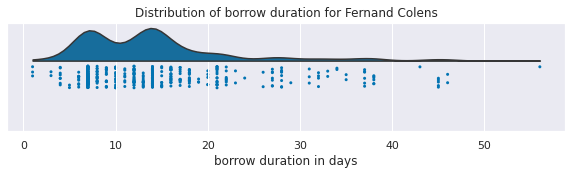

In [44]:
# borrow duration
colens_borrows = events_df[events_df.member_id.isin(['colens-fernand']) & (events_df.event_type == 'Borrow')]
raincloud_borrow_plot(colens_borrows, 'colen_borrow_duration_raincloud_plot.png', 'Fernand Colens')

In [45]:
pb_membership_details('colens-fernand')

# Membership activities

## Subscription history

,event_type,subscription_purchase_date,start_date,end_date,subscription_price_paid,subscription_deposit,subscription_duration_days,subscription_volumes,subscription_category,reimbursement_refund
851,Subscription,1920-04-01,1920-04-01,1920-05-01,8.0,14.0,30.0,2.0,NaN,NaN
857,Subscription,1920-04-07,1920-04-07,1920-07-07,17.1,NaN,91.0,1.0,Professor / Teacher,NaN
30084,Subscription,1920-10-30,1920-10-30,1921-04-30,40.0,NaN,182.0,2.0,Professor / Teacher,NaN
30273,Renewal,1921-06-29,1921-06-29,1921-09-29,24.0,NaN,92.0,2.0,NaN,NaN
30377,Renewal,1921-10-27,1921-10-27,1922-04-27,40.0,NaN,182.0,2.0,NaN,NaN
30568,Renewal,1922-05-16,1922-05-16,1922-08-16,24.0,NaN,92.0,2.0,NaN,NaN
2385,Renewal,1922-10-07,1922-10-07,1923-04-07,40.0,NaN,182.0,2.0,AdL,NaN
30950,Renewal,1923-06-25,1923-06-25,1923-09-25,24.0,NaN,92.0,2.0,AdL,NaN
3123,Supplement,1923-07-02,1923-07-02,1923-10-02,16.0,NaN,92.0,NaN,NaN,NaN
3450,Renewal,1923-10-26,1923-10-26,1924-10-26,64.0,NaN,366.0,2.0,AdL,NaN


## Subscriptions with categories specified

,event_type,subscription_purchase_date,start_date,end_date,subscription_price_paid,subscription_deposit,subscription_duration_days,subscription_volumes,subscription_category,reimbursement_refund
857,Subscription,1920-04-07,1920-04-07,1920-07-07,17.1,NaN,91.0,1.0,Professor / Teacher,NaN
30084,Subscription,1920-10-30,1920-10-30,1921-04-30,40.0,NaN,182.0,2.0,Professor / Teacher,NaN
2385,Renewal,1922-10-07,1922-10-07,1923-04-07,40.0,NaN,182.0,2.0,AdL,NaN
30950,Renewal,1923-06-25,1923-06-25,1923-09-25,24.0,NaN,92.0,2.0,AdL,NaN
3450,Renewal,1923-10-26,1923-10-26,1924-10-26,64.0,NaN,366.0,2.0,AdL,NaN
7379,Renewal,1926-11-26,1926-11-26,1927-11-26,120.0,NaN,365.0,2.0,AdL,NaN
9453,Renewal,1928-11-03,1928-11-01,1929-11-01,120.0,NaN,365.0,2.0,Professor / Teacher,NaN
10830,Renewal,1929-11-09,1929-11-01,1930-11-01,120.0,NaN,365.0,2.0,Professor / Teacher,NaN


## Subscription volumes

count    22.000000
mean      1.863636
std       0.351250
min       1.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       2.000000
Name: subscription_volumes, dtype: float64

# Borrowing activities

## borrow duration

count    502.000000
mean      14.197211
std        8.447499
min        1.000000
25%        7.000000
50%       14.000000
75%       16.000000
max       56.000000
Name: borrow_duration_days, dtype: float64

## longest borrows

,borrow_duration_days,item_uri,item_title,start_date,end_date
9184,56.0,https://shakespeareandco.princeton.edu/books/m...,Poems,1928-07-18,1928-09-12
11549,46.0,https://shakespeareandco.princeton.edu/books/s...,Shelley's Works,1930-08-25,1930-10-10
9210,46.0,https://shakespeareandco.princeton.edu/books/b...,The Poems and Plays of Robert Browning,1928-07-28,1928-09-12
23166,45.0,https://shakespeareandco.princeton.edu/books/o...,The Poems of Wilfred Owen,1938-07-26,1938-09-09
23164,45.0,https://shakespeareandco.princeton.edu/books/s...,Shelley's Works,1938-07-26,1938-09-09
23167,45.0,https://shakespeareandco.princeton.edu/books/m...,The Modern Poet: An Anthology,1938-07-26,1938-09-09
23165,45.0,https://shakespeareandco.princeton.edu/books/s...,Harmonium,1938-07-26,1938-09-09
13912,45.0,https://shakespeareandco.princeton.edu/books/r...,New Signatures: Poems by Several Hands,1933-05-17,1933-07-01
11177,43.0,https://shakespeareandco.princeton.edu/books/r...,Phases of English Poetry,1930-03-14,1930-04-26
21091,38.0,https://shakespeareandco.princeton.edu/books/m...,Selected Poems of Thomas Sturge Moore,1937-07-27,1937-09-03


## shortest borrows

,borrow_duration_days,item_uri,item_title,start_date,end_date
16399,1.0,https://shakespeareandco.princeton.edu/books/w...,The Cambridge History of English Literature,1935-02-08,1935-02-09
11061,1.0,https://shakespeareandco.princeton.edu/books/c...,The Criterion,1930-01-17,1930-01-18
24040,1.0,https://shakespeareandco.princeton.edu/books/g...,Mary Shelley: A Biography,1939-01-14,1939-01-15
15380,3.0,https://shakespeareandco.princeton.edu/books/n...,"Curzon: The Last Phase, 1919 – 1925, a Study o...",1934-05-14,1934-05-17
21503,3.0,https://shakespeareandco.princeton.edu/books/h...,To Have and Have Not,1937-11-09,1937-11-12
10125,4.0,https://shakespeareandco.princeton.edu/books/s...,Queen Victoria,1929-04-13,1929-04-17
14999,4.0,https://shakespeareandco.princeton.edu/books/e...,Poems,1934-02-20,1934-02-24
26072,4.0,https://shakespeareandco.princeton.edu/books/f...,What I Believe,1939-12-01,1939-12-05
22645,4.0,https://shakespeareandco.princeton.edu/books/i...,Lions and Shadows: An Education in the Twenties,1938-04-29,1938-05-03
9151,4.0,https://shakespeareandco.princeton.edu/books/l...,Twilight in Italy,1928-07-07,1928-07-11


## format of items borrowed

Book          492
Periodical     16
Name: item_format, dtype: int64

## genres borrowed

fiction                            100
biography                           89
bibliography                        46
criticism, interpretation, etc.     37
novel                               36
text                                16
drama                               12
history                             11
poetry                              10
psychological fiction.               8
domestic fiction.                    7
essay                                6
love stories.                        5
historical fiction.                  4
autobiographical fiction.            4
modernist literature                 3
satire                               3
correspondence                       3
tragedies                            2
experimental literature              2
Name: term, dtype: int64

## subject borrowed

english literature              28
english poetry                  22
english fiction                 12
literature                      12
fiction                         12
description and travel          11
poetry                          11
travel                          10
history                         10
english drama                   10
american poetry                 10
poets, english                   9
authors, english                 9
intellectual life                8
social life and customs          8
england                          8
manners and customs              7
literature, modern               6
biography                        6
criticism                        6
criticism and interpretation     6
great britain                    6
communism                        5
social problems                  5
young men                        5
Name: term, dtype: int64

## most borrowed authors

Lawrence, D. H.                        12
Forster, E. M.                         10
Eliot, T. S.                           10
Nicolson, Harold George                 9
Woolf, Virginia                         9
Yeats, William Butler                   8
Spender, Stephen                        7
Maugham, W. Somerset                    7
Faulkner, William                       6
Aldington, Richard                      6
Read, Herbert                           5
Shaw, George Bernard                    5
Douglas, Norman                         5
Huxley, Aldous                          5
Strachey, Giles Lytton                  5
Hemingway, Ernest                       5
Auden, W. H.;Isherwood, Christopher     5
Baring, Maurice                         5
Morgan, Charles                         5
Priestley, J. B.                        4
Lewis, Wyndham                          4
Pound, Ezra                             4
Powys, John Cowper                      4
Powys, Theodore Francis           

## repeat borrows?

,total
item_uri,
https://shakespeareandco.princeton.edu/books/ward-cambridge-history-english/,10
https://shakespeareandco.princeton.edu/books/criterion/,5
https://shakespeareandco.princeton.edu/books/read-phases-english-poetry/,4
https://shakespeareandco.princeton.edu/books/lehmann-new-writing/,3
https://shakespeareandco.princeton.edu/books/ker-form-style-poetry/,3
https://shakespeareandco.princeton.edu/books/auden-dog-beneath-skin/,2
https://shakespeareandco.princeton.edu/books/richardson-dawns-left-hand/,2
https://shakespeareandco.princeton.edu/books/nicolson-swinburne/,2
https://shakespeareandco.princeton.edu/books/peck-shelley-life-work/,2


## any unique borrows?

55 unique borrows (47 excluding unclear)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,start_date,item_id,item_borrow_count,item_uncertain
8798,1928-02-23,donne-donnes-sermons-selected,1.0,False
8995,1928-05-23,rossetti-princes-progress,1.0,False
9366,1928-10-06,bradbrook-history-elizabethan-drama,1.0,False
9417,1928-10-20,pronunciation-english,1.0,True
9927,1929-02-23,lucas-colvins-friends,1.0,False
9977,1929-03-09,richardson-familiar-letters-important,1.0,False
9978,1929-03-09,gower,1.0,True
10124,1929-04-13,coates-eater-darkness,1.0,False
10273,1929-05-11,recollection,1.0,True
10296,1929-05-18,lowell-legends,1.0,False


## Raphael

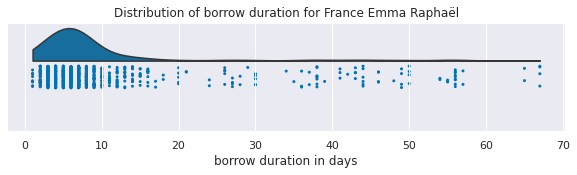

In [46]:
# borrow duration
raphael_borrows = events_df[events_df.member_id.isin(['raphael-france']) & (events_df.event_type == 'Borrow')]
raincloud_borrow_plot(raphael_borrows, 'raphael_borrow_duration_raincloud_plot.png', 'France Emma Raphaël')

In [47]:
# Raphael is second most prolific borrower after Killen; how many did she have?
events_df[events_df.member_id.isin(['killen']) & (events_df.event_type == 'Borrow')].shape[0]


1480

In [48]:
pb_membership_details('raphael-france')


# Membership activities

## Subscription history

,event_type,subscription_purchase_date,start_date,end_date,subscription_price_paid,subscription_deposit,subscription_duration_days,subscription_volumes,subscription_category,reimbursement_refund
893,Subscription,1920-04-30,1920-04-30,1920-07-30,12.0,NaN,91.0,1.0,NaN,NaN
1000,Renewal,1920-07-27,1920-07-30,1920-10-30,12.0,NaN,92.0,1.0,NaN,NaN
1061,Renewal,1920-10-26,1920-10-30,1921-04-30,16.0,NaN,182.0,1.0,NaN,NaN
30237,Renewal,1921-05-17,1921-05-17,1921-11-17,28.0,NaN,184.0,1.0,NaN,NaN
1704,Renewal,1921-11-02,1921-11-17,1922-05-17,28.0,NaN,181.0,1.0,NaN,NaN
2117,Renewal,1922-05-15,1922-04-30,1923-04-30,48.0,NaN,365.0,1.0,AdL,NaN
2996,Renewal,1923-05-05,1923-04-30,1924-04-30,48.0,NaN,366.0,1.0,AdL,NaN
4055,Renewal,1924-05-12,1924-04-30,1925-04-30,60.0,NaN,365.0,1.0,NaN,NaN
5163,Renewal,1925-04-30,1925-04-30,1926-04-30,90.0,NaN,365.0,1.0,NaN,NaN
6539,Renewal,1926-04-28,1926-04-20,1927-04-20,115.0,NaN,365.0,1.0,NaN,NaN


## Subscriptions with categories specified

,event_type,subscription_purchase_date,start_date,end_date,subscription_price_paid,subscription_deposit,subscription_duration_days,subscription_volumes,subscription_category,reimbursement_refund
2117,Renewal,1922-05-15,1922-04-30,1923-04-30,48.0,NaN,365.0,1.0,AdL,NaN
2996,Renewal,1923-05-05,1923-04-30,1924-04-30,48.0,NaN,366.0,1.0,AdL,NaN
25281,Renewal,1939-06-02,1939-06-02,1940-06-02,300.0,NaN,366.0,1.0,B,NaN


## Subscription volumes

count    24.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: subscription_volumes, dtype: float64

# Borrowing activities

## borrow duration

count    963.000000
mean       9.668744
std       11.392420
min        1.000000
25%        4.000000
50%        7.000000
75%        8.000000
max       67.000000
Name: borrow_duration_days, dtype: float64

## longest borrows

,borrow_duration_days,item_uri,item_title,start_date,end_date
13033,67.0,https://shakespeareandco.princeton.edu/books/d...,Whiteoaks,1932-08-01,1932-10-07
13034,67.0,https://shakespeareandco.princeton.edu/books/m...,Buddenbrooks,1932-08-01,1932-10-07
13038,67.0,https://shakespeareandco.princeton.edu/books/h...,The Return of the Native,1932-08-01,1932-10-07
13032,67.0,https://shakespeareandco.princeton.edu/books/b...,The Sentimentalists,1932-08-01,1932-10-07
4573,65.0,https://shakespeareandco.princeton.edu/books/w...,The Apple of the Eye,1924-10-23,1924-12-27
6877,65.0,https://shakespeareandco.princeton.edu/books/s...,The Growth of the Soul,1926-07-17,1926-09-20
21153,57.0,https://shakespeareandco.princeton.edu/books/t...,All Hands!,1937-08-04,1937-09-30
21154,57.0,https://shakespeareandco.princeton.edu/books/h...,The Other Side,1937-08-04,1937-09-30
3202,56.0,https://shakespeareandco.princeton.edu/books/d...,South Wind,1923-08-06,1923-10-01
3200,56.0,https://shakespeareandco.princeton.edu/books/h...,The Bright Shawl,1923-08-06,1923-10-01


## shortest borrows

,borrow_duration_days,item_uri,item_title,start_date,end_date
23318,1.0,https://shakespeareandco.princeton.edu/books/a...,American Comedy,1938-10-05,1938-10-06
7490,1.0,https://shakespeareandco.princeton.edu/books/s...,Far End,1926-12-16,1926-12-17
6057,1.0,https://shakespeareandco.princeton.edu/books/g...,The Glory of the Conquered: The Story of a Gre...,1926-01-18,1926-01-19
12894,1.0,https://shakespeareandco.princeton.edu/books/s...,"Far from My Home: Stories, Long and Short",1932-05-20,1932-05-21
4117,1.0,https://shakespeareandco.princeton.edu/books/b...,The Romantic Woman,1924-05-19,1924-05-20
27149,1.0,https://shakespeareandco.princeton.edu/books/g...,The Power and the Glory,1940-05-21,1940-05-22
7895,1.0,https://shakespeareandco.princeton.edu/books/n...,The Hard-Boiled Virgin,1927-05-02,1927-05-03
10706,1.0,https://shakespeareandco.princeton.edu/books/m...,Slaves of the Gods,1929-09-27,1929-09-28
25312,1.0,https://shakespeareandco.princeton.edu/books/j...,Finnegans Wake,1939-06-08,1939-06-09
2050,1.0,https://shakespeareandco.princeton.edu/books/t...,Alice Adams,1922-03-26,1922-03-27


## format of items borrowed

Book          975
Periodical      1
Name: item_format, dtype: int64

## genres borrowed

fiction                            420
novel                              105
biography                           97
bibliography                        47
domestic fiction.                   28
psychological fiction.              23
text                                22
love stories.                       19
history                             18
historical fiction.                 13
bildungsromans.                     11
detective and mystery stories.      11
historical novel                     9
criticism, interpretation, etc.      7
roman anglais                        7
english fiction                      7
humorous fiction.                    6
war stories.                         6
autobiographical fiction.            6
satire.                              5
Name: term, dtype: int64

## subject borrowed

fiction                                36
history                                23
social life and customs                14
authors, english                       13
travel                                 12
english literature                     11
women                                  11
manners and customs                    10
united states                           9
english fiction                         9
description and travel                  9
novelists, english                      9
young men                               8
adultery                                8
politics and government                 8
married people                          8
young women                             8
great britain                           8
british                                 7
inheritance and succession              7
triangles (interpersonal relations)     7
social classes                          6
journalists                             6
authors                           

## most borrowed authors

Huxley, Aldous            13
Forster, E. M.            13
Cather, Willa             12
Lawrence, D. H.           12
Maugham, W. Somerset      11
Sinclair, May             11
McKenna, Stephen          11
Macaulay, Rose            10
Ford, Ford Madox          10
Delafield, E. M.          10
Woolf, Virginia           10
Stern, G. B.              10
Dos Passos, John           9
Bromfield, Louis           8
Thompson, Sylvia           8
Swinnerton, Frank          8
Kennedy, Margaret          8
Lewis, Sinclair            8
Aldington, Richard         8
Hurst, Fannie              7
Van Vechten, Carl          7
Wharton, Edith             7
Kaye-Smith, Sheila         7
Strachey, Giles Lytton     7
Anderson, Sherwood         7
Dane, Clemence             7
Faulkner, William          7
Mackenzie, Compton         6
Deeping, Warwick           6
Borden, Mary               6
Name: item_authors, dtype: int64

## repeat borrows?

,total
item_uri,
https://shakespeareandco.princeton.edu/books/hare-describe-circle/,3
https://shakespeareandco.princeton.edu/books/glasgow-sheltered-life/,3
https://shakespeareandco.princeton.edu/books/dos-passos-big-money/,3
https://shakespeareandco.princeton.edu/books/cather-one/,3
https://shakespeareandco.princeton.edu/books/louis-bromfield-today-gone-tomorrow/,2
...,...
https://shakespeareandco.princeton.edu/books/field-heaven/,2
https://shakespeareandco.princeton.edu/books/ferber-american-beauty/,2
https://shakespeareandco.princeton.edu/books/faulkner-absalom-absalom/,2


## any unique borrows?

92 unique borrows (85 excluding unclear)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,start_date,item_id,item_borrow_count,item_uncertain
2092,1922-04-18,leslie-oppidan,1.0,False
2248,1922-07-10,couperus-hidden-story-modern,1.0,False
2250,1922-07-10,fleay-almond-blossoms,1.0,False
2395,1922-10-11,moore-single-strictness,1.0,False
2497,1922-11-18,benet-beginning-wisdom,1.0,False
...,...,...,...,...
26137,1939-12-16,grierson-sir-walter-scott,1.0,False
26983,1940-04-18,oldfield-hudson-rejoins-herd,1.0,False
27351,1940-09-04,somerville-mount-music,1.0,False
27371,1940-09-13,somervile-dan-russel-fox,1.0,False


## Kittredge

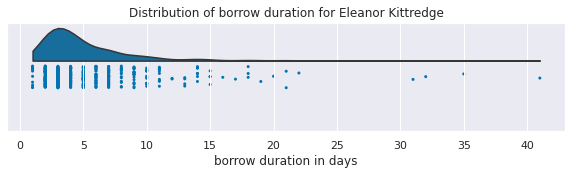

In [49]:
#  borrow duration
kittredge_borrows = events_df[events_df.member_id.isin(['kittredge-eleanor-hayden']) & (events_df.event_type == 'Borrow')]
raincloud_borrow_plot(kittredge_borrows, 'kittredge_borrow_duration_raincloud_plot.png', 'Eleanor Kittredge')

In [50]:
pb_membership_details('kittredge-eleanor-hayden')


# Membership activities

## Subscription history

,event_type,subscription_purchase_date,start_date,end_date,subscription_price_paid,subscription_deposit,subscription_duration_days,subscription_volumes,subscription_category,reimbursement_refund
3706,Subscription,1924-01-17,1924-01-17,1924-04-17,40.0,40.0,91.0,2.0,NaN,NaN
4016,Renewal,1924-04-17,1924-04-17,1924-05-17,16.0,NaN,30.0,2.0,NaN,NaN
4201,Reimbursement,NaN,1924-06-16,1924-06-16,NaN,NaN,NaN,NaN,NaN,40.0
31538,Subscription,1924-11-24,1924-11-24,1925-02-24,40.0,40.0,92.0,2.0,NaN,NaN
31651,Renewal,1925-03-12,1925-03-12,1925-06-12,40.0,NaN,92.0,2.0,NaN,NaN
5325,Renewal,1925-06-05,1925-06-12,1925-09-12,40.0,NaN,92.0,2.0,NaN,NaN
5553,Renewal,1925-09-05,1925-09-12,1925-12-12,40.0,NaN,91.0,2.0,NaN,NaN
32030,Renewal,1925-12-23,1925-12-23,1926-03-23,40.0,NaN,90.0,2.0,NaN,NaN
33101,Renewal,1928-09-05,1928-09-05,1928-12-05,85.0,NaN,91.0,2.0,NaN,NaN
33488,Subscription,1929-09-10,1929-09-10,1929-12-10,85.0,NaN,91.0,2.0,NaN,NaN


## Subscriptions with categories specified

,event_type,subscription_purchase_date,start_date,end_date,subscription_price_paid,subscription_deposit,subscription_duration_days,subscription_volumes,subscription_category,reimbursement_refund
16565,Renewal,1935-03-14,1935-03-14,NaN,NaN,NaN,NaN,NaN,Day By Day,NaN


## Subscription volumes

count    19.0
mean      2.0
std       0.0
min       2.0
25%       2.0
50%       2.0
75%       2.0
max       2.0
Name: subscription_volumes, dtype: float64

# Borrowing activities

## borrow duration

count    545.000000
mean       5.214679
std        4.252569
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       41.000000
Name: borrow_duration_days, dtype: float64

## longest borrows

,borrow_duration_days,item_uri,item_title,start_date,end_date
19371,41.0,https://shakespeareandco.princeton.edu/books/j...,The Letters of Henry James,1936-10-13,1936-11-23
21591,35.0,https://shakespeareandco.princeton.edu/books/r...,For Us in the Dark,1937-11-22,1937-12-27
19372,32.0,https://shakespeareandco.princeton.edu/books/j...,The Portrait of a Lady,1936-10-13,1936-11-14
16329,31.0,https://shakespeareandco.princeton.edu/books/a...,The Letters of Henry Adams,1935-01-28,1935-02-28
21675,22.0,https://shakespeareandco.princeton.edu/books/w...,Axel's Castle: A Study in the Imaginative Lite...,1937-12-06,1937-12-28
22347,21.0,https://shakespeareandco.princeton.edu/books/l...,Seven Pillars of Wisdom,1938-03-12,1938-04-02
16541,21.0,https://shakespeareandco.princeton.edu/books/j...,The Art of the Novel: Critical Prefaces,1935-03-08,1935-03-29
18200,20.0,https://shakespeareandco.princeton.edu/books/g...,The Letters of Vincent van Gogh to His Brother...,1936-02-25,1936-03-16
14209,19.0,https://shakespeareandco.princeton.edu/books/h...,The Intimate Papers of Colonel House,1933-09-16,1933-10-05
14695,18.0,https://shakespeareandco.princeton.edu/books/g...,Oblomov,1933-12-28,1934-01-15


## shortest borrows

,borrow_duration_days,item_uri,item_title,start_date,end_date
18006,1.0,https://shakespeareandco.princeton.edu/books/m...,The New Statesman and Nation,1936-01-27,1936-01-28
14329,1.0,https://shakespeareandco.princeton.edu/books/h...,The Great Offensive,1933-10-24,1933-10-25
18845,1.0,https://shakespeareandco.princeton.edu/books/m...,Time and Tide,1936-05-29,1936-05-30
18327,1.0,https://shakespeareandco.princeton.edu/books/m...,Time and Tide,1936-03-13,1936-03-14
16992,1.0,https://shakespeareandco.princeton.edu/books/m...,Time and Tide,1935-06-18,1935-06-19
16999,1.0,https://shakespeareandco.princeton.edu/books/m...,The New Statesman and Nation,1935-06-18,1935-06-19
18326,1.0,https://shakespeareandco.princeton.edu/books/m...,The New Statesman and Nation,1936-03-13,1936-03-14
19695,1.0,https://shakespeareandco.princeton.edu/books/c...,Cards on the Table,1936-12-04,1936-12-05
20077,1.0,https://shakespeareandco.princeton.edu/books/s...,The London Mercury,1937-02-09,1937-02-10
17275,1.0,https://shakespeareandco.princeton.edu/books/v...,The Curtain Rises,1935-09-20,1935-09-21


## format of items borrowed

Book          306
Periodical    261
Name: item_format, dtype: int64

## genres borrowed

fiction                            105
biography                           52
detective and mystery stories.      33
novel                               15
bibliography                        14
text                                13
history                              9
criticism, interpretation, etc.      8
detective novel                      5
bildungsromans.                      5
periodicals                          4
historical fiction.                  4
mystery fiction.                     4
psychological fiction.               4
love stories.                        4
autobiography                        4
mystery fiction                      3
crime novel                          3
essay                                3
short stories                        3
Name: term, dtype: int64

## subject borrowed

private investigators      16
fiction                    14
politics and government    13
history                     9
world war, 1914-1918        8
communism                   7
journalists                 7
peace                       7
war                         7
police                      6
american literature         6
intellectual life           6
authors, american           6
description and travel      5
authors, english            5
great britain               5
young men                   5
english literature          4
short stories, american     4
authors                     4
novelists, english          4
novelists                   4
literature, modern          4
social life and customs     4
english poetry              4
Name: term, dtype: int64

## most borrowed authors

Christie, Agatha                              6
Dannay, Frederic;Lee, Manfred B.              5
Nicolson, Harold George                       5
Sayers, Dorothy L.                            5
Van Dine, S. S.                               4
Spender, Stephen                              4
James, Henry                                  4
Keynes, John Maynard                          4
Kennedy, Milward                              3
Wilson, Edmund                                3
Boyle, Kay                                    3
Maugham, W. Somerset                          3
Thompson, Sylvia                              3
Bromfield, Louis                              3
Orwell, George                                2
Reilly, Helen                                 2
Hart, Frances Noyes                           2
Wells, H. G.                                  2
Aldington, Richard                            2
O'Hara, John                                  2
Bridge, Ann                             

## repeat borrows?

,total
item_uri,
https://shakespeareandco.princeton.edu/books/mackworth-time-tide/,103
https://shakespeareandco.princeton.edu/books/martin-new-statesman-nation/,96
https://shakespeareandco.princeton.edu/books/croly-new-republic/,16
https://shakespeareandco.princeton.edu/books/kirchwey-nation/,11
https://shakespeareandco.princeton.edu/books/new-masses/,9
https://shakespeareandco.princeton.edu/books/hartman-harpers-magazine/,7
https://shakespeareandco.princeton.edu/books/ross-new-yorker/,5
https://shakespeareandco.princeton.edu/books/sedgwick-atlantic-monthly/,4
https://shakespeareandco.princeton.edu/books/cross-yale-review/,3


## any unique borrows?

20 unique borrows (17 excluding unclear)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,start_date,item_id,item_borrow_count,item_uncertain
14192,1933-09-08,atherton-adventures-novelist,1.0,False
14193,1933-09-08,boleslavski-lances-fires-moscow,1.0,False
14387,1933-11-04,keynes-short-view-russia,1.0,False
14388,1933-11-04,keynes-revision-treaty,1.0,False
14397,1933-11-04,keynes-end-laissez,1.0,False
14454,1933-11-15,woolf-intelligent-mans-way,1.0,False
14455,1933-11-15,angell-chaos-control,1.0,False
16268,1935-01-16,gilfillan-went-pit-college,1.0,False
16975,1935-06-13,fr,1.0,True
17243,1935-09-14,hoyt-elinor-wylie-portrait,1.0,False


## Hemingway

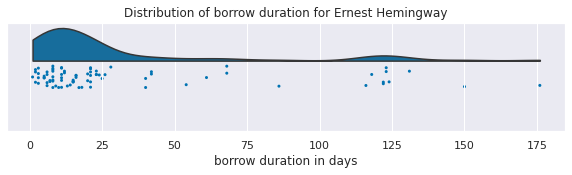

In [51]:
# borrow duration
hemingway_borrows = events_df[events_df.member_id.isin(['hemingway-ernest']) & (events_df.event_type == 'Borrow')]
raincloud_borrow_plot(hemingway_borrows, 'hemingway_borrow_duration_raincloud_plot.png', 'Ernest Hemingway')

In [52]:

pb_membership_details('hemingway-ernest')


# Membership activities

## Subscription history

,event_type,subscription_purchase_date,start_date,end_date,subscription_price_paid,subscription_deposit,subscription_duration_days,subscription_volumes,subscription_category,reimbursement_refund
1818,Subscription,1921-12-28,1921-12-28,1922-01-28,12.0,NaN,31.0,2.0,NaN,NaN
30498,Renewal,1922-02-27,1922-02-27,1922-05-27,20.0,NaN,89.0,1.0,NaN,NaN
30638,Renewal,1922-08-08,1922-08-08,1922-11-08,30.0,NaN,92.0,2.0,NaN,NaN
31242,Renewal,1924-03-28,1924-03-28,1925-03-28,86.0,NaN,365.0,2.0,NaN,NaN
5056,Renewal,1925-05-30,1925-03-23,1926-03-23,50.0,NaN,365.0,NaN,NaN,NaN
6362,Renewal,1926-10-11,1926-03-23,1927-03-23,150.0,NaN,365.0,2.0,NaN,NaN


## Subscriptions with categories specified

,event_type,subscription_purchase_date,start_date,end_date,subscription_price_paid,subscription_deposit,subscription_duration_days,subscription_volumes,subscription_category,reimbursement_refund


## Subscription volumes

count    5.000000
mean     1.800000
std      0.447214
min      1.000000
25%      2.000000
50%      2.000000
75%      2.000000
max      2.000000
Name: subscription_volumes, dtype: float64

# Borrowing activities

## borrow duration

count     80.000000
mean      31.987500
std       41.182672
min        1.000000
25%        8.000000
50%       15.000000
75%       26.500000
max      176.000000
Name: borrow_duration_days, dtype: float64

## longest borrows

,borrow_duration_days,item_uri,item_title,start_date,end_date
6651,176.0,https://shakespeareandco.princeton.edu/books/t...,Knock Knock Knock and Other Stories,1926-05-10,1926-11-02
6619,150.0,https://shakespeareandco.princeton.edu/books/h...,Far Away and Long Ago,1926-05-04,1926-10-01
6627,131.0,https://shakespeareandco.princeton.edu/books/n...,Thus Spake Zarathustra: A Book for All and None,1926-05-05,1926-09-13
5916,124.0,https://shakespeareandco.princeton.edu/books/h...,Children of the Age,1925-12-10,1926-04-13
6649,123.0,https://shakespeareandco.princeton.edu/books/t...,The Two Friends and Other Stories,1926-05-10,1926-09-10
6652,123.0,https://shakespeareandco.princeton.edu/books/t...,On the Eve,1926-05-10,1926-09-10
7244,122.0,https://shakespeareandco.princeton.edu/books/a...,On the Trail of Ancient Man,1926-10-29,1927-02-28
6661,122.0,https://shakespeareandco.princeton.edu/books/r...,The Problems of Philosophy,1926-05-14,1926-09-13
10705,118.0,https://shakespeareandco.princeton.edu/books/d...,The Idiot,1929-09-27,1930-01-23
7265,116.0,https://shakespeareandco.princeton.edu/books/s...,Composition as Explanation,1926-11-04,1927-02-28


## shortest borrows

,borrow_duration_days,item_uri,item_title,start_date,end_date
8395,1.0,https://shakespeareandco.princeton.edu/books/l...,Time and Western Man,1927-10-18,1927-10-19
8035,2.0,https://shakespeareandco.princeton.edu/books/l...,The Story of a Wonder Man: Being the Autobiogr...,1927-06-11,1927-06-13
10348,2.0,https://shakespeareandco.princeton.edu/books/r...,A Bookman's Daybook,1929-06-03,1929-06-05
8751,2.0,https://shakespeareandco.princeton.edu/books/m...,The Riddle of the Irish,1928-02-11,1928-02-13
10424,3.0,https://shakespeareandco.princeton.edu/books/m...,Contemporary Russian Literature: 1881 – 1925,1929-06-21,1929-06-24
23241,3.0,https://shakespeareandco.princeton.edu/books/l...,The Dead Don't Care,1938-09-07,1938-09-10
10446,3.0,https://shakespeareandco.princeton.edu/books/b...,"Politicians and the War, 1914 – 1916",1929-06-29,1929-07-02
5840,3.0,https://shakespeareandco.princeton.edu/books/o...,The Terrible Hobby of Sir Joseph Londe,1925-11-28,1925-12-01
8811,5.0,https://shakespeareandco.princeton.edu/books/g...,The Wonder Book of the Wild: The Romance of Ex...,1928-03-03,1928-03-08
6107,5.0,https://shakespeareandco.princeton.edu/books/c...,The Doctor Looks at Literature: Psychological ...,1926-01-28,1926-02-02


## format of items borrowed

Book          94
Periodical    20
Name: item_format, dtype: int64

## genres borrowed

fiction                            25
biography                          17
bibliography                        9
novel                               8
history                             4
bildungsroman                       3
domestic fiction.                   3
periodicals                         3
criticism, interpretation, etc.     3
detective and mystery stories.      3
existentialist novel                2
autobiography                       2
novella                             2
personal narratives                 2
social novel                        2
text                                2
historical novel                    2
literary realism                    1
political fiction                   1
period novel                        1
Name: term, dtype: int64

## subject borrowed

history                    5
literature, modern         5
politics and government    4
description and travel     4
social life and customs    3
voyages and travels        3
world war, 1914-1918       3
literature                 3
parodies                   2
hunting                    2
spain                      2
psychological fiction      2
authors                    2
fiction                    2
paleontology               2
working class women        2
philosophy                 2
natural history            2
middle ages                2
american literature        2
novelists, english         2
authors, english           2
travel                     2
biography                  2
social conditions          2
Name: term, dtype: int64

## most borrowed authors

Turgenev, Ivan             12
Dostoyevsky, Fyodor         3
Garnett, David              2
Hunt, Violet                2
Mann, Thomas                2
Stein, Gertrude             2
Lawrence, D. H.             2
Huneker, James              2
Lowndes, Marie Belloc       2
Tomlinson, H. M.            2
Sitwell, Osbert             2
Graves, Robert              1
Figgis, Darrell             1
Douglas, Alfred             1
Smith, Walton Hall          1
Molony, J. Chartres         1
Wassermann, Jakob           1
O'Neill, Eugene             1
O'Casey, Sean               1
Golding, Harry              1
Ludwig, Emil                1
Wilder, Thornton            1
Dostoevskaia, Anna          1
Josephson, Matthew          1
Lenotre, G.                 1
Barnum, P. T.               1
Rascoe, Burton              1
Mirsky, D. S.               1
Chester, Samuel Beach       1
Beaverbrook, Max Aitken     1
Name: item_authors, dtype: int64

## repeat borrows?

,total
item_uri,
https://shakespeareandco.princeton.edu/books/canby-saturday-review-literature/,9
https://shakespeareandco.princeton.edu/books/thayer-dial/,3
https://shakespeareandco.princeton.edu/books/turgenev-sportsmans-sketches/,3
https://shakespeareandco.princeton.edu/books/lehmann-new-writing/,2
https://shakespeareandco.princeton.edu/books/turgenev-eve/,2
https://shakespeareandco.princeton.edu/books/turgenev-torrents-spring/,2


## any unique borrows?

23 unique borrows (21 excluding unclear)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,start_date,item_id,item_borrow_count,item_uncertain
5629,1925-10-08,sinclair-mammonart-essay-economic,1.0,False
5686,1925-10-22,turgenev-lear-steppes-stories,1.0,False
5816,1925-11-23,stewart-parody-outline-history,1.0,False
5820,1925-11-24,hunt-tales-uneasy,1.0,False
5840,1925-11-28,oppenheim-terrible-hobby-sir,1.0,False
5918,1925-12-10,turgenev-house-gentlefolk-novel,1.0,False
6123,1926-01-30,bull-fighting,1.0,True
6624,1926-05-04,huneker-steeplejack,1.0,False
6651,1926-05-10,turgenev-knock-knock-knock,1.0,False
7244,1926-10-29,andrews-trail-ancient-man,1.0,False
